# Testing MGP example from GPytorch docs

In [2]:
import numpy as np
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

In [4]:
Train_x = train_x.unsqueeze(0).repeat(4,1)

In [5]:
shifts = torch.tensor([1,-0.5,0,0.7]).unsqueeze(-1)
frequencies = torch.tensor([2,0.5,3,1]).unsqueeze(-1)

In [6]:
Train_y = torch.stack([
    torch.sin(Train_x * (2*frequencies* math.pi) + shifts ) + torch.randn(Train_x.size()) * 0.2,
    torch.cos(Train_x * (3*frequencies* math.pi) + shifts ) + torch.randn(Train_x.size()) * 0.2,
], -1)

In [244]:
a = torch.tensor(float('nan')) 

In [249]:
Train_y[0,0,0] = float('nan')

In [7]:
def plot_data(Train_x, Train_y):
    n_samples = Train_x.shape[0]
    fig, ax = plt.subplots(n_samples, figsize=(10,10))
    for i, (x,y) in enumerate(zip(Train_x, Train_y)):
        ax[i].plot(x,y)
        

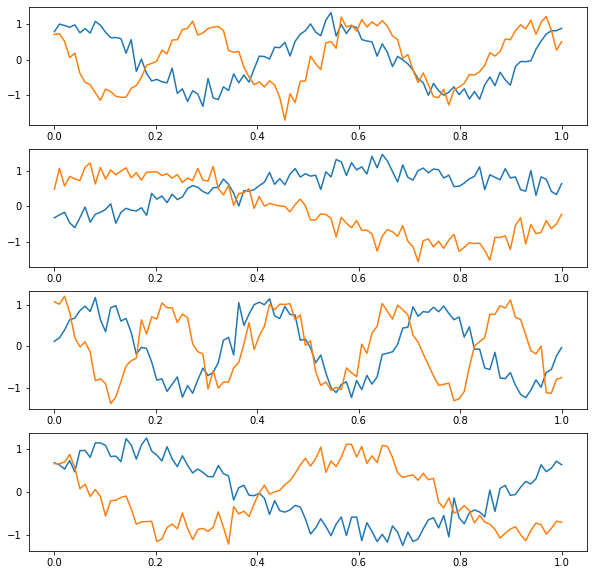

In [8]:
plot_data(Train_x, Train_y)

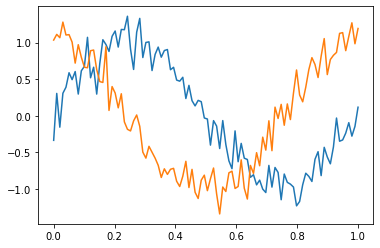

In [142]:
plt.plot(train_x, train_y)

In [10]:
#MGP Model Class
class MultitaskGPModel(gpytorch.models.ExactGP ):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)



In [15]:
train_x = Train_x
train_y = Train_y

In [12]:
train_x = train_x.unsqueeze(-1)

In [16]:
train_x.shape

torch.Size([4, 100])

In [17]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [18]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y).mean() #.mean()
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

RuntimeError: The size of tensor a (200) must match the size of tensor b (8) at non-singleton dimension 1

In [223]:
for param_name, param in model.named_parameters():
    print(f'Name: {param_name} Value = {param.data}')

Name: likelihood.raw_noise Value = tensor([-3.9215])
Name: likelihood.noise_covar.raw_noise Value = tensor([-3.8298, -4.0096])
Name: mean_module.base_means.0.constant Value = tensor([0.1997])
Name: mean_module.base_means.1.constant Value = tensor([0.1597])
Name: covar_module.task_covar_module.covar_factor Value = tensor([[ 0.5300],
        [-0.0372]])
Name: covar_module.task_covar_module.raw_var Value = tensor([-1.1952, -0.1046])
Name: covar_module.data_covar_module.raw_lengthscale Value = tensor([[-2.1759]])


In [241]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51).unsqueeze(0).repeat(4,1).unsqueeze(-1)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task


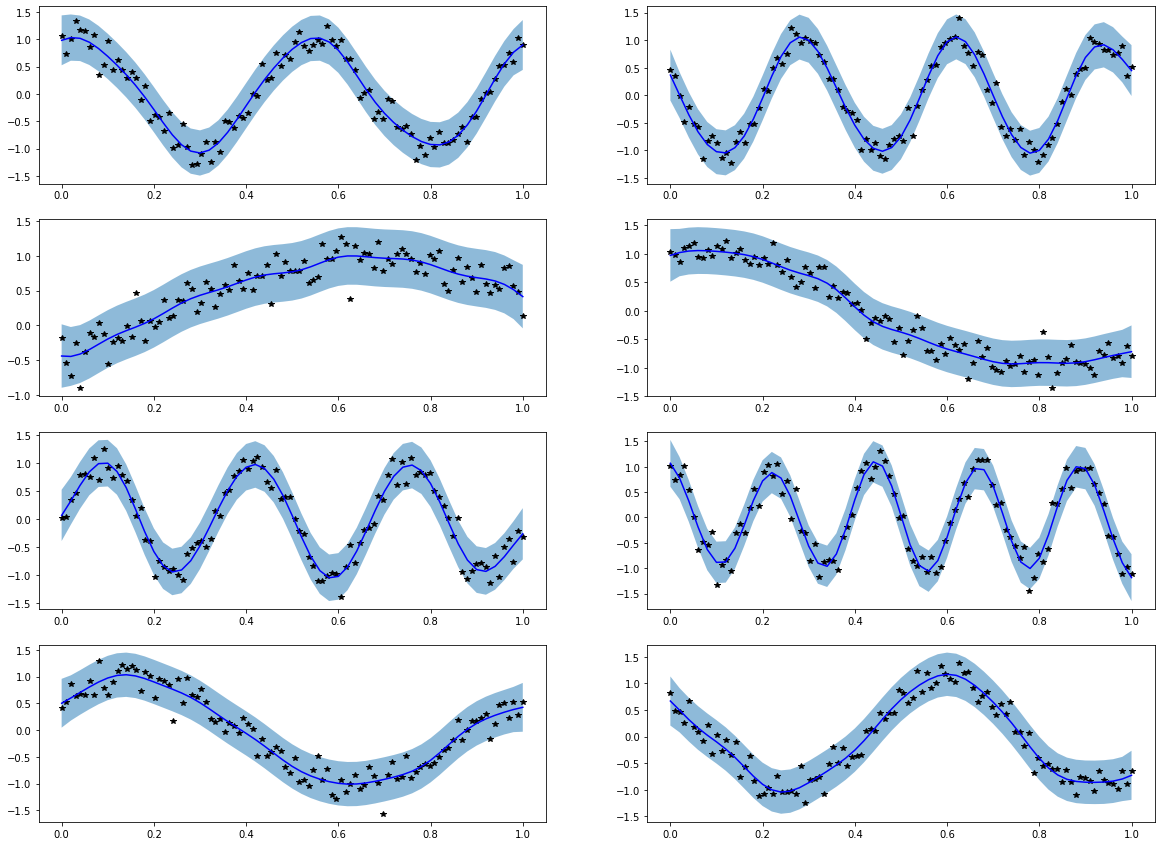

In [242]:
# Initialize plots
f, ax = plt.subplots(4, 2, figsize=(20, 15))

n_samples = test_x.shape[0]
n_tasks = train_y.shape[-1]
for i in np.arange(n_samples):
    for j in np.arange(n_tasks):
        # Plot training data as black stars
        ax[i,j].plot(train_x[i].detach().numpy(), train_y[i,:,j].detach().numpy(), 'k*')
        
        # Predictive mean as blue line
        ax[i,j].plot(test_x[i].numpy(), mean[i,:,j].numpy(), 'b')
        # Shade in confidence
        ax[i,j].fill_between(test_x[i].numpy().squeeze(), lower[i,:,j].numpy(), upper[i,:,j].numpy(), alpha=0.5)
        #ax[i,j].set_ylim([-3, 3])
        #ax[i,j].legend(['Observed Data', 'Mean', 'Confidence'])
        #ax[i,j].set_title('Observed Values (Likelihood)')


(51,)

In [ ]:
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')